*****
In this notebook I am going to attempt to make some models.  

I expect to have to refine features and adjust for things to make the models better. I do NOT expect things to work on the first try.   

I have different kinds of data to incorporate that i created with feature engineering, like the win rate per map per hero for each player, and same thing for match mode (domination, convergence, convoy). I'll see what happens if I try to incorporate it, and how i would even incorporate it.  

I also have the match history in terms of team compositions. I still have to figure out the best way to utilize this data. I have the team compositions and overall win rates for each team composition. But overall I feel like theres not enough matches retrieved, and wayyy too many unique team compositions possible to get a proper insight into this. This is probably something that requires millions of matches that only the people at NetEase games (developers) can have access to and analyze, but I will make an attempt. 

*****

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

hero_data = pd.read_csv("trimmed_hero_data.csv")
map_winrate = pd.read_csv("hero_map_winrate.csv")
mode_winrate = pd.read_csv("hero_mode_winrate.csv")

hero_data.head()


,player_id,hero_name,role,timePlayed_value,matchesWinPct_value,matchesPlayed_value,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played
0,VP Sypeh,Gambit,strategist,37388.742,69.135802,48.6,4.075556,9.626667,881.0,2983.0,682.0,280,18,7,55.159494
1,VP Sypeh,Invisible Woman,strategist,14769.481,63.934426,18.3,4.962500,11.475000,1294.0,3169.0,1516.0,79,7,5,21.789369
2,VP Sypeh,Emma Frost,vanguard,1275.047,71.428571,1.4,3.363636,4.545455,2404.0,0.0,3061.0,13,0,0,1.881073
3,VP Sypeh,Loki,strategist,7069.450,93.220339,11.8,5.400000,13.400000,957.0,2267.0,511.0,31,4,0,10.429537
4,VP Sypeh,Adam Warlock,strategist,2216.817,53.333333,3.0,2.750000,4.850000,1272.0,1596.0,727.0,28,0,0,3.270463


Here, i want the model to train and learn to predict what the long term win rates will be for their heroes, and from there i can use it to recommend the top 3 heroes and their values of predicted win rates to help guide players to pick the best heroes for them to use.   

Some players have played with a lot of heroes, it can be hard to decide on which ones to consistently use, but limited to past information on their playtime/experience with these heroes (so it doesnt really work for brand new heroes, or heroes theyve never played before)   

This model helps them realize which heroes are allowing them to win more games, so they can use them more in competetive matches. 

since role is very important, ill use one-hot encoding to match the role with a number   

there are 3 roles, so i will do: 

strategist = 1
duelist = 2
vanguard = 3

def onehot_encode_roles(df):
    if df['role'] == 'support': 
        return 1
    elif df['role'] == 'duelist':
        return 2
    elif df['role'] == 'vanguard':
        return 3

hero_data['role_one_hot'] = hero_data.apply(onehot_encode_roles, axis=1)


In [2]:
#i cant just label it 1,2,3, because then the model might try to compare them numerically, 
#i need to make it so it chooses one value or another
#like if the role is duelist, then strategist and vanguard are both 0 and it will get rid of their variables 
def onehot_encode_roles(df):
    if df['role'] == 'strategist': 
        return pd.Series([1,0,0])
    elif df['role'] == 'duelist':
        return pd.Series([0,1,0])
    elif df['role'] == 'vanguard':
        return pd.Series([0,0,1])

hero_data[['role_strategist', 'role_duelist', 'role_vanguard']] = hero_data.apply(onehot_encode_roles, axis=1)
hero_data 


,player_id,hero_name,role,timePlayed_value,matchesWinPct_value,matchesPlayed_value,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played,role_strategist,role_duelist,role_vanguard
0,VP Sypeh,Gambit,strategist,37388.742,69.135802,48.6,4.075556,9.626667,881.0,2983.0,682.0,280,18,7,55.159494,1,0,0
1,VP Sypeh,Invisible Woman,strategist,14769.481,63.934426,18.3,4.962500,11.475000,1294.0,3169.0,1516.0,79,7,5,21.789369,1,0,0
2,VP Sypeh,Emma Frost,vanguard,1275.047,71.428571,1.4,3.363636,4.545455,2404.0,0.0,3061.0,13,0,0,1.881073,0,0,1
3,VP Sypeh,Loki,strategist,7069.450,93.220339,11.8,5.400000,13.400000,957.0,2267.0,511.0,31,4,0,10.429537,1,0,0
4,VP Sypeh,Adam Warlock,strategist,2216.817,53.333333,3.0,2.750000,4.850000,1272.0,1596.0,727.0,28,0,0,3.270463,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,DecaDonald,Loki,strategist,37808.155,57.201646,48.6,2.886207,7.500000,701.0,2287.0,642.0,154,6,6,37.585012,1,0,0
3953,DecaDonald,Invisible Woman,strategist,9567.059,33.628319,11.3,2.098901,5.571429,677.0,2592.0,1288.0,26,0,0,9.510594,1,0,0
3954,DecaDonald,Rocket Raccoon,strategist,13100.055,59.067358,19.3,1.400000,6.410526,207.0,1988.0,444.0,30,0,0,13.022739,1,0,0
3955,DecaDonald,Venom,vanguard,1613.943,40.000000,2.5,2.117647,2.941176,1095.0,0.0,2685.0,17,0,0,1.604418,0,0,1


*****
Just like I did in lab4, will split the data into 90% train, 10% test and then scale it for linear regression
*****

In [3]:
from sklearn.model_selection import train_test_split
features = ['kdRatio_value', 'kdaRatio_value', 'totalHeroDamagePerMinute_value', 'totalHeroHealPerMinute_value', 'totalDamageTakenPerMinute_value', 'lastKills_value', 'totalMvp_value', 'totalSvp_value', 'percent_of_time_played', 'role_strategist', 'role_duelist', 'role_vanguard']
X = hero_data[features]
y = hero_data['matchesWinPct_value']
#splitting to 90/10 train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) 

normalize data

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler() #need to separate scalars to keep the x and y separate, in a sense making 2 scaler objects that can act on our data 
scaler_Y = MinMaxScaler()

X_scaled_values = scaler_X.fit_transform(X_train)

#problems with y not being able to be reshaped since its a series object not a df 
#Y_scaled_values = scaler_Y.fit_transform(y_train.values.reshape(-1,1)) #need to reshape the array to be 2-d in order for the function to work to make a numpy array

x_train_scaled_vals = X_scaled_values
#i shouldnt scale the y train values bc its a single output value
#y_train_scaled_vals = Y_scaled_values
y_train_scaled_vals = y_train

since there's no point in doing the l2 loss manually, will just use the library estimators (sklearn) to do the linear regression:

In [5]:
from sklearn.linear_model import LinearRegression 
lm = LinearRegression()
result = lm.fit(x_train_scaled_vals,y_train_scaled_vals)
print(result.intercept_)
print(result.coef_)

43.78694566526914
[127.41005835  84.92624265 -15.73055099 -21.64281892   2.02373643
  19.61158251  49.20789388 -88.84924419  22.18859181   5.13619732
  -1.57159724  -3.56460008]


I realized that without keeping the hero name and player id before scaling x_test, i basically have no actual labels to connect the prediction with the application/meaning of it! 

In [6]:
X_test_all_cols = X_test.copy()
X_test_all_cols['player_id'] = hero_data.loc[X_test.index, 'player_id']
X_test_all_cols['hero_name'] = hero_data.loc[X_test.index, 'hero_name']
X_test_all_cols

,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played,role_strategist,role_duelist,role_vanguard,player_id,hero_name
149,5.688172,7.010753,2054.0,0.0,2872.0,180,3,0,35.889111,0,0,1,Nеcrize,Emma Frost
1025,5.194444,5.194444,2796.0,0.0,929.0,80,2,0,4.393895,0,1,0,happyhamster6,Moon Knight
2153,2.422222,7.055556,781.0,2227.0,489.0,33,2,0,11.826720,1,0,0,Dinks,Loki
720,3.639344,4.431694,2091.0,82.0,4686.0,232,4,2,56.344918,0,0,1,Unovvn,Groot
325,2.777778,3.277778,1595.0,0.0,2383.0,15,0,0,3.196457,0,0,1,TreeMan.1,Magneto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,3.777778,8.898148,991.0,2230.0,535.0,101,1,0,7.852134,1,0,0,MilleDidrik,Jeff The Land Shark
3884,3.500000,3.750000,1621.0,0.0,4298.0,15,0,0,5.566670,0,0,1,斩尽杀绝,Groot
1345,1.750000,2.312500,1334.0,0.0,1401.0,12,0,0,0.689531,0,1,0,Evil GomaKazi,Daredevil
69,7.392857,8.821429,2019.0,0.0,3019.0,78,0,0,7.674053,0,0,1,energу,Magneto


In [7]:
x_Test_scaled = scaler_X.transform(X_test)

make the prediction using the model and the test set

In [8]:
scaled_prediction_sk = lm.predict(x_Test_scaled)

In [9]:
print(scaled_prediction_sk)

[ 77.90052877  62.40780172  57.43552455  66.50121652  50.47813253
  45.53053405  64.02111496  46.88302503  41.17698108  43.92028129
  55.06581502  46.23973303  83.80269601  64.53579237  68.15943241
  48.22162615  58.93882932  58.66989563  52.85296022  68.35570456
  56.10368214  57.34286182  61.51070848  58.69106867  53.9158463
  56.25773252  55.5311045   66.54246475  45.3464129   72.54725092
  55.65611923  54.25555143  39.34276389  56.06074285  39.93422754
  71.67124526  69.31820583  58.24757005  54.3773029   81.31512745
  72.61375414  57.41763224  55.60594303  54.39513042  45.45248578
  41.89328342  64.99342817  62.48483942  46.58238894  45.98733441
  54.68546728  55.84002761  52.43851563  55.59219421  66.00727273
  59.13815495  77.80853049  56.20496187  56.04347094  42.38518949
  50.1069295   56.29798572  73.6585945   52.71613159  51.60712938
  53.71638406  43.87312184  41.0131236   57.88434337  98.39723754
  59.34936489  45.14932371  49.33991707  50.07797798  71.79391472
  48.998168

In [10]:
print(scaled_prediction_sk.shape)

(396,)


In [11]:
y_test.shape

(396,)

arrays match shapes of the test set and the size of the y-test (to compare for accuracy)

check error for model accuracy

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, scaled_prediction_sk)
r2 = r2_score(y_test, scaled_prediction_sk)

print(mse)
print(mse**0.5)
print(r2)


332.2260119548444
18.22706811187264
0.3043314823319706


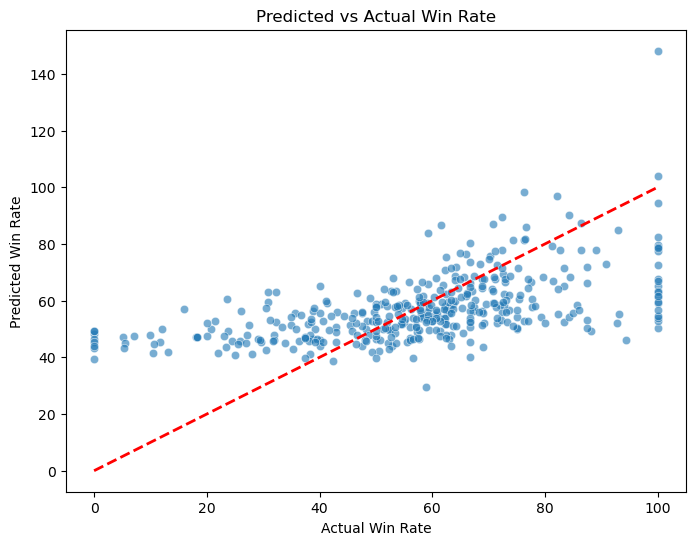

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=scaled_prediction_sk, alpha=0.6)

# reference line (perfect predictions)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")
plt.title("Predicted vs Actual Win Rate")
plt.show()


*****
This means that, looking at sqrt(mse) = mean error = ME means that my model has +/- 18% error. That is honestly not too bad, and I am surprised it even works. I will work to make this better.  

Looking at r2, this means that only 30% of the variation of the data is explained by this model. That is way too low. I need to improve this, but I am using linear regression which doesn't think too much about internal correlation of features, which my dataset does have as seen by the heatmaps that I did before. 
*****

remaking the dataframe so i can compare the outputs of the prediction and the real values directly:

In [14]:
prediction_results = X_test.copy()
prediction_results['Predicted Win %'] = scaled_prediction_sk.flatten()
prediction_results['Actual Win %'] = y_test.values.flatten()

prediction_results.head()

,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played,role_strategist,role_duelist,role_vanguard,Predicted Win %,Actual Win %
149,5.688172,7.010753,2054.0,0.0,2872.0,180,3,0,35.889111,0,0,1,77.900529,82.692308
1025,5.194444,5.194444,2796.0,0.0,929.0,80,2,0,4.393895,0,1,0,62.407802,72.727273
2153,2.422222,7.055556,781.0,2227.0,489.0,33,2,0,11.826720,1,0,0,57.435525,63.194444
720,3.639344,4.431694,2091.0,82.0,4686.0,232,4,2,56.344918,0,0,1,66.501217,72.818792
325,2.777778,3.277778,1595.0,0.0,2383.0,15,0,0,3.196457,0,0,1,50.478133,100.000000


In [15]:
prediction_results_with_ids = X_test_all_cols.copy()
prediction_results_with_ids['Predicted Win %'] = scaled_prediction_sk.flatten()
prediction_results_with_ids['Actual Win %'] = y_test.values.flatten()
prediction_results_with_ids

,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played,role_strategist,role_duelist,role_vanguard,player_id,hero_name,Predicted Win %,Actual Win %
149,5.688172,7.010753,2054.0,0.0,2872.0,180,3,0,35.889111,0,0,1,Nеcrize,Emma Frost,77.900529,82.692308
1025,5.194444,5.194444,2796.0,0.0,929.0,80,2,0,4.393895,0,1,0,happyhamster6,Moon Knight,62.407802,72.727273
2153,2.422222,7.055556,781.0,2227.0,489.0,33,2,0,11.826720,1,0,0,Dinks,Loki,57.435525,63.194444
720,3.639344,4.431694,2091.0,82.0,4686.0,232,4,2,56.344918,0,0,1,Unovvn,Groot,66.501217,72.818792
325,2.777778,3.277778,1595.0,0.0,2383.0,15,0,0,3.196457,0,0,1,TreeMan.1,Magneto,50.478133,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,3.777778,8.898148,991.0,2230.0,535.0,101,1,0,7.852134,1,0,0,MilleDidrik,Jeff The Land Shark,63.582339,61.373391
3884,3.500000,3.750000,1621.0,0.0,4298.0,15,0,0,5.566670,0,0,1,斩尽杀绝,Groot,55.327655,82.352941
1345,1.750000,2.312500,1334.0,0.0,1401.0,12,0,0,0.689531,0,1,0,Evil GomaKazi,Daredevil,46.935572,37.500000
69,7.392857,8.821429,2019.0,0.0,3019.0,78,0,0,7.674053,0,0,1,energу,Magneto,77.817158,86.315789


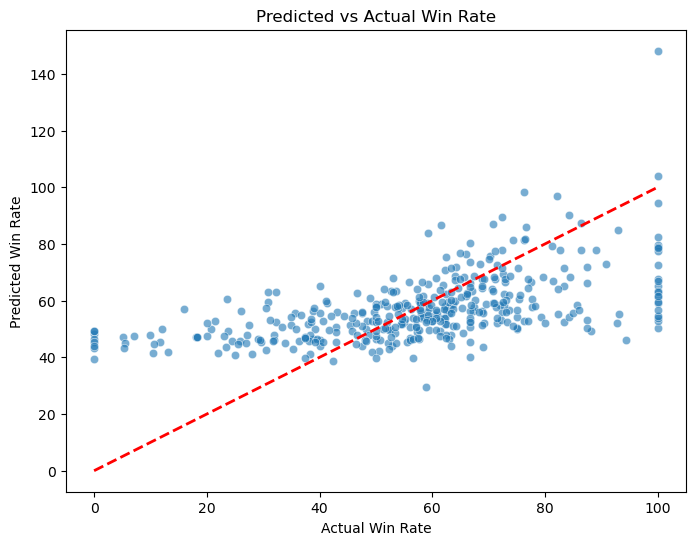

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=scaled_prediction_sk, alpha=0.6)

#reference line 
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")
plt.title("Predicted vs Actual Win Rate")
plt.show()


*****
I want to test naive bayes. I want to see if I can classify data into not likely, likely, highly likely to win a match
*****

I will set win rate less than 40 to be unlikely, 40-60 to be unsure, and >60 to be likely

In [17]:
#need to split up the data and classify it based on win percentage ranges 
def classify_win_percentage(win_pct):
    if win_pct < 40:
        return 'Low likelihood'
    elif 40 <= win_pct < 60:
        return 'Medium likelihood'
    else:
        return 'High likelihood'

In [18]:
naive_bayes_heroes_df = hero_data.copy()
naive_bayes_heroes_df['Win_Likelihood'] = naive_bayes_heroes_df['matchesWinPct_value'].apply(classify_win_percentage)
naive_bayes_heroes_df

,player_id,hero_name,role,timePlayed_value,matchesWinPct_value,matchesPlayed_value,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played,role_strategist,role_duelist,role_vanguard,Win_Likelihood
0,VP Sypeh,Gambit,strategist,37388.742,69.135802,48.6,4.075556,9.626667,881.0,2983.0,682.0,280,18,7,55.159494,1,0,0,High likelihood
1,VP Sypeh,Invisible Woman,strategist,14769.481,63.934426,18.3,4.962500,11.475000,1294.0,3169.0,1516.0,79,7,5,21.789369,1,0,0,High likelihood
2,VP Sypeh,Emma Frost,vanguard,1275.047,71.428571,1.4,3.363636,4.545455,2404.0,0.0,3061.0,13,0,0,1.881073,0,0,1,High likelihood
3,VP Sypeh,Loki,strategist,7069.450,93.220339,11.8,5.400000,13.400000,957.0,2267.0,511.0,31,4,0,10.429537,1,0,0,High likelihood
4,VP Sypeh,Adam Warlock,strategist,2216.817,53.333333,3.0,2.750000,4.850000,1272.0,1596.0,727.0,28,0,0,3.270463,1,0,0,Medium likelihood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,DecaDonald,Loki,strategist,37808.155,57.201646,48.6,2.886207,7.500000,701.0,2287.0,642.0,154,6,6,37.585012,1,0,0,Medium likelihood
3953,DecaDonald,Invisible Woman,strategist,9567.059,33.628319,11.3,2.098901,5.571429,677.0,2592.0,1288.0,26,0,0,9.510594,1,0,0,Low likelihood
3954,DecaDonald,Rocket Raccoon,strategist,13100.055,59.067358,19.3,1.400000,6.410526,207.0,1988.0,444.0,30,0,0,13.022739,1,0,0,Medium likelihood
3955,DecaDonald,Venom,vanguard,1613.943,40.000000,2.5,2.117647,2.941176,1095.0,0.0,2685.0,17,0,0,1.604418,0,0,1,Medium likelihood


In [19]:
y_train

45      62.068966
3694    84.210526
183     77.192982
1632    72.000000
3378    74.742268
          ...    
1130    68.000000
1294    54.807692
860     50.746269
3507    43.333333
3174    61.538462
Name: matchesWinPct_value, Length: 3561, dtype: float64

In [20]:
y_test

149      82.692308
1025     72.727273
2153     63.194444
720      72.818792
325     100.000000
           ...    
1074     61.373391
3884     82.352941
1345     37.500000
69       86.315789
2614     18.181818
Name: matchesWinPct_value, Length: 396, dtype: float64

In [21]:
print(type(y_train))

<class 'pandas.core.series.Series'>


In [22]:
#setting the y value for naive bayes
y = naive_bayes_heroes_df['Win_Likelihood']

from sklearn.naive_bayes import GaussianNB #guassian nb is navie bayes on sklearn
gnb = GaussianNB()

#have scaled variables already but re making them in case using the scalers and x train and x test we already have 
X_GNB_train_scaled = scaler_X.transform(X_train)
X_GNB_test_scaled = scaler_X.transform(X_test)

#setting up the y values for naive bayes classification using the y_train and y_test series that are already made 
y_train_GNB = y_train.apply(classify_win_percentage)
y_test_GNB = y_test.apply(classify_win_percentage)

gnb.fit(X_GNB_train_scaled, y_train_GNB)
gnb_predictions = gnb.predict(X_GNB_test_scaled)

training done and predictions done, now time to test the outputs/results

from sklearn documentation:  
https://scikit-learn.org/stable/modules/naive_bayes.html

In [23]:
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test_GNB != gnb_predictions).sum()))

Number of mislabeled points out of a total 396 points : 203


In [24]:
#so our naive bayes accuracy is 
accuracy = 203/396
print(accuracy)

0.5126262626262627


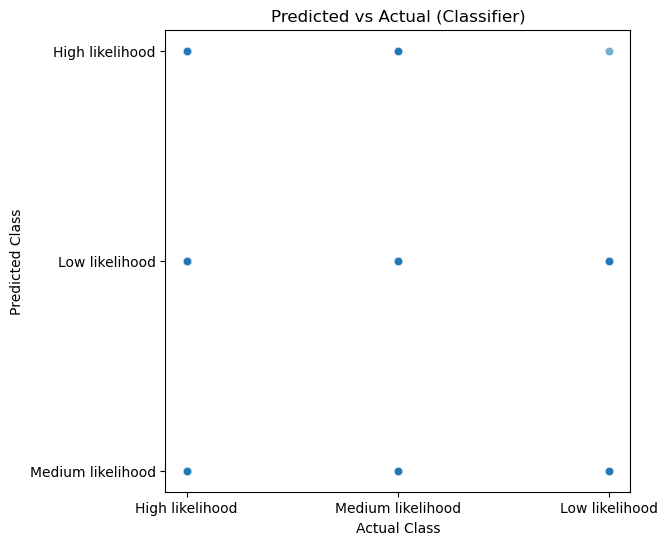

In [25]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_GNB, y=gnb_predictions, alpha=0.6)
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.title("Predicted vs Actual (Classifier)")
plt.show()


from sklearn documentation:   
https://scikit-learn.org/stable/modules/model_evaluation.html   

zero-one loss is good for "predict, categorical" meaning for categorical prediction, which is what 
the naive bayes classification kind of did, put the prediction as one of 3 classifiers 

In [26]:
from sklearn.metrics import zero_one_loss
print(zero_one_loss(y_test_GNB, gnb_predictions))


0.5126262626262627


Well, it is surprisingly still about 51% accurate, but that's not enough, and it's just categorical classification, which is not too insightful anyway. It was good to test, but not something I can use 

*****
Next, I want to try out the models in the Ensembles section of scikit learn docs. Here they talk about how ensemble methods combine the predictions of several base estimators using a given learning algorithm, and it improves generalizability.   

In addition, histogram gradient boosting classifier algorithm can handle categorical data natively, which means I can leave in categorical data and not have to mess with the dataset to prepare it for the model. 


https://scikit-learn.org/stable/modules/ensemble.html
*****

Histogram Based Gradient Boosting: Requires classifications (categorical) so I will have to use the same data format as the naive bayes one for this specifically

In [27]:
#need to split up the data and classify it based on win percentage ranges 
def classify_more_specific_win_percentage(win_pct):
    if win_pct < 40:
        return 'not likely'
    elif 40 <= win_pct < 60:
        return 'even likelihood'
    elif 60 <= win_pct < 70:
        return 'likely'
    else:
        return 'very likely'

In [28]:
histogram_heroes_df = hero_data.copy()
histogram_heroes_df['Win_Likelihood'] = histogram_heroes_df['matchesWinPct_value'].apply(classify_more_specific_win_percentage)
histogram_heroes_df

,player_id,hero_name,role,timePlayed_value,matchesWinPct_value,matchesPlayed_value,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played,role_strategist,role_duelist,role_vanguard,Win_Likelihood
0,VP Sypeh,Gambit,strategist,37388.742,69.135802,48.6,4.075556,9.626667,881.0,2983.0,682.0,280,18,7,55.159494,1,0,0,likely
1,VP Sypeh,Invisible Woman,strategist,14769.481,63.934426,18.3,4.962500,11.475000,1294.0,3169.0,1516.0,79,7,5,21.789369,1,0,0,likely
2,VP Sypeh,Emma Frost,vanguard,1275.047,71.428571,1.4,3.363636,4.545455,2404.0,0.0,3061.0,13,0,0,1.881073,0,0,1,very likely
3,VP Sypeh,Loki,strategist,7069.450,93.220339,11.8,5.400000,13.400000,957.0,2267.0,511.0,31,4,0,10.429537,1,0,0,very likely
4,VP Sypeh,Adam Warlock,strategist,2216.817,53.333333,3.0,2.750000,4.850000,1272.0,1596.0,727.0,28,0,0,3.270463,1,0,0,even likelihood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,DecaDonald,Loki,strategist,37808.155,57.201646,48.6,2.886207,7.500000,701.0,2287.0,642.0,154,6,6,37.585012,1,0,0,even likelihood
3953,DecaDonald,Invisible Woman,strategist,9567.059,33.628319,11.3,2.098901,5.571429,677.0,2592.0,1288.0,26,0,0,9.510594,1,0,0,not likely
3954,DecaDonald,Rocket Raccoon,strategist,13100.055,59.067358,19.3,1.400000,6.410526,207.0,1988.0,444.0,30,0,0,13.022739,1,0,0,even likelihood
3955,DecaDonald,Venom,vanguard,1613.943,40.000000,2.5,2.117647,2.941176,1095.0,0.0,2685.0,17,0,0,1.604418,0,0,1,even likelihood


In [29]:
#set the y train and y test for histogram based classification
y_train_hist = y_train.apply(classify_more_specific_win_percentage)
y_test_hist = y_test.apply(classify_more_specific_win_percentage)

In [30]:
from sklearn.ensemble import HistGradientBoostingClassifier
#.ravel() is used to convert y_train from a 2D array to a 1D array, necessary a lot in ML libraries

#for this i dont need to scale the data, the algorithm works without it
clf = HistGradientBoostingClassifier(max_iter=300).fit(X_train, y_train_hist)
clf_prediction = clf.predict(X_test)

clf.score(X_test, y_test_hist)


0.4444444444444444

for classifier, .score() actually returns accuracy, so bigger the better, but accuracy of just 0.44 is not good

There's also the HistGradientBoostRegressor, which I can use more effectively with continuious variables like with my main objective with the percentage odds of winning based on past win %

In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(max_iter=300).fit(X_train, y_train)
hgb_prediction = hgb.predict(X_test)
hgb.score(X_test, y_test)

0.3024568968197323

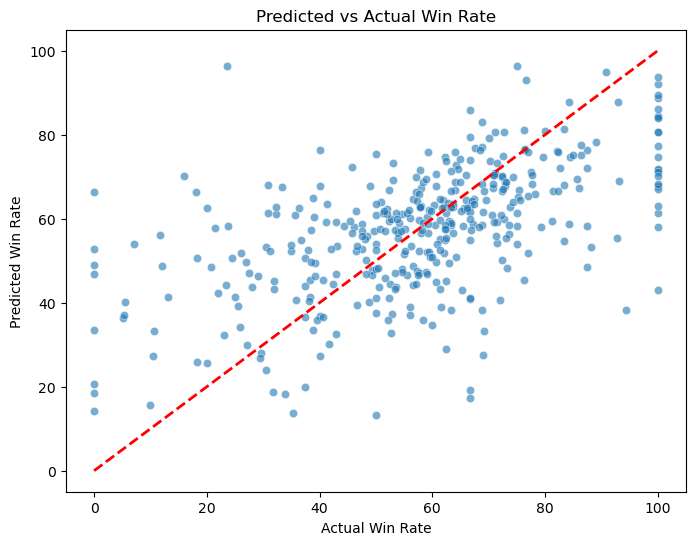

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=hgb_prediction, alpha=0.6)

#reference line 
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")
plt.title("Predicted vs Actual Win Rate")
plt.show()


for regressors, .score() returns R^2 value    

unfortunately this model is bad because it only has an R^2 of 0.3, so it's basically useless

So far somehow the basic linear regression has been the strongest

Brainstorming:   

I think since I've used some more advanced models now and the model's are not performing very well, it might indicate that perhaps I do not have enough features/covariates that I'm considering.   

I think that I need to definitely incorporate some more measured features that could help understand the win rates.  

Some of this is measured but tricky for me think of how to incorporate meaningully, some of it is simply not measured data, some of it is hard to think about how to make it work: 
 - teammates 
    - people you know, heroes that synergize 
 - opponent players 
    - really good enemy players at certain roles, or heroes that are direct counter play to your hero
 - time of day
    - the player pool online is different at different times of day, including across the world and in general when player counts are high (work, school, free time)
 - player mood
    - sometimes players can be on a win streak or loss streak, affecting their mental state and frustration can cascade into poor performance
 - meta changes -> not an issue
    - at least the data is taken from near the latter half of season 5.0 (season 5.5 update is this Friday 12/12!)
 - queue randomness
    - some players get matched up just poorly or they get teammates that all play 1-2 roles and can result in a forced pick into a weaker role by someone
 - maps
    - some maps have things that give certain heroes advantages over others
 - game mode 
    - some game modes might prove advantageous for certain heroes 
 - individual player randomness/error
    - could just randomly have a bad game for random reasons 
 - time played that day continuously
    - some players could be playing for a few hours, near end of longer sessions can be more fatigued than others, and can affect ability to concentrate, be alert, be awake, and be as sharp/quick thinking

*****
Out of the above, these are features that I can incorporate into the main data table since I have the data just need to make it formatted to work with the current table: 
- teammates/synergies
- opponents/counters
- map affect on hero performance
- match mode affect on hero performance 
*****

But really quickly before I do that: 

I read about Random forests  

This is a tree algorithm but it also introduces randomness in the construction of it.   

I am going to try out the RandomForestClassifier and RandomForestRegressor models/algorithms. 

I think that this randomness factor could work in favor of modeling some of those variables I just mentioned above which we cannot really measure, and is kind of random. Either it helps capture this noise or it may introduce other randomness which we don't need, since the data right now lacks sufficient features to be providing accurate enough predictions

In [33]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=None)
rfc.fit(X_train, y_train)
rfc_prediction = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.3821931846573181

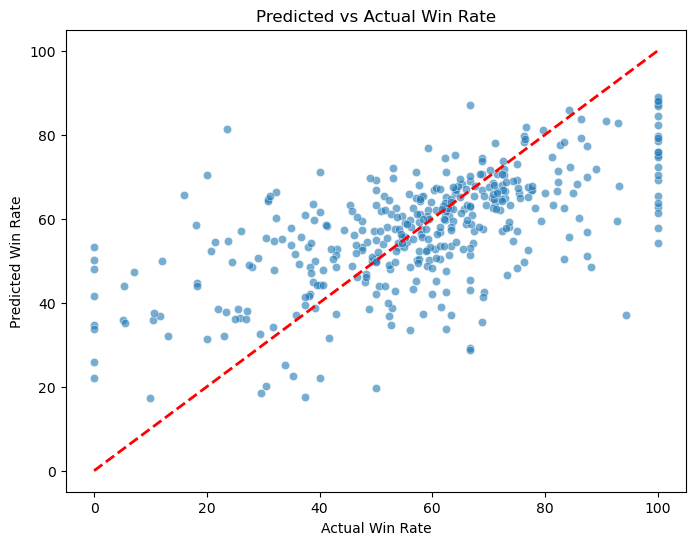

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=rfc_prediction, alpha=0.6)

#reference line 
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")
plt.title("Predicted vs Actual Win Rate")
plt.show()


*****
The R2 is improved at 0.38 but still not anywhere acceptable. I am going to go add the features to the dataset, then re-run the models in a 2nd notebook
*****